In [1]:
import os
import gc
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import rc
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.transforms import Bbox
from matplotlib.patches import FancyBboxPatch
from matplotlib.font_manager import FontProperties

from functions.mandyocIO import read_mandyoc_output, read_datasets, read_particle_path

# Initial setup

In [2]:
# Path to the model directory
# model_path = "/home/kugelblitz/runs/strak_57"
model_path = "/Users/assuncao/Desktop/_phase-test-true-0"

read_ascii = False # if False, it will skip the ascii reading and saving processes and it will read the datasets from previous runs
plot_first = True # Generate and plot only the first image
save_images = False # Generate and save all the possible images
follow_particle = False # Stores x and z position of a particle through the simulation
make_video = False # Make video witll all the possible imagesTrue
make_gif = False # Make an animated gif with the generated video

# Datasets handeling
## Model path

In [36]:
# Create the output directory to save the dataset
output_path = os.path.join(model_path, "_output")
if not os.path.isdir(output_path):
    os.makedirs(output_path)

model_name = os.path.split(model_path)[1]

datasets = ("temperature", "density")
# datasets = ("temperature", "viscosity", "strain_rate", "surface", "velocity", "density")

### Read ascii outputs and save them as xarray.Datasets

In [37]:
# Read data and convert them to xarray.Dataset
if (read_ascii):
    ds_data = read_mandyoc_output(
        model_path,
        datasets=datasets,
        parameters_file="param.txt"
    )

In [38]:
if (follow_particle):    
    particle_x, particle_z, particle_ID = read_particle_path(
        model_path,
        (2_400.0e3, -100.0e3),
        unit_number=3,
        ncores=np.nan
    )

In [39]:
if (follow_particle):
    x_disp = abs(particle_x[-1] - particle_x[0])
    z_disp = abs(particle_z[-1] - particle_z[0])
    print("X displacement:", x_disp/1.0e3, "[km]")
    print("Z displacement:", z_disp/1.0e3, "[km]")
    plt.figure(figsize=(x_disp*2/z_disp, 4), facecolor="white")
    plt.title(f'Particle {int(particle_ID)} trajectory')
    plt.plot(particle_x/1.0e3, particle_z/1.0e3, color='grey')
    plt.scatter(particle_x/1.0e3, particle_z/1.0e3, color='grey')
    plt.scatter(particle_x[0]/1.0e3, particle_z[0]/1.0e3, color='blue', label='Begin', zorder=10) # zorder must be big to be on top of the other plots
    plt.scatter(particle_x[-1]/1.0e3, particle_z[-1]/1.0e3, color='red', label='End', zorder=10)
    plt.legend()
    plt.xlabel("x [km]")
    plt.ylabel("z [km]")
    plt.savefig(f"{output_path}/{model_name}_output_trajectory_{int(particle_ID)}.png", dpi=300)

## Read and merge saved datasets into a single dataset

In [40]:
if (save_images) or (plot_first):
    dataset = read_datasets(model_path, datasets)

    # Normalize velocity values
    if ("velocity_x" and "velocity_x") in dataset.data_vars:
        v_max = np.max((dataset.velocity_x**2 + dataset.velocity_z**2)**(0.5))    
        dataset.velocity_x[:] = dataset.velocity_x[:] / v_max
        dataset.velocity_z[:] = dataset.velocity_z[:] / v_max

    print(dataset)

<xarray.Dataset>
Dimensions:      (x: 81, z: 81, time: 41)
Coordinates:
  * x            (x) float64 0.0 1.25e+03 2.5e+03 ... 9.75e+04 9.875e+04 1e+05
  * z            (z) float64 -1e+05 -9.875e+04 -9.75e+04 ... -1.25e+03 0.0
  * time         (time) float64 0.0 0.4528 0.8432 1.188 ... 4.961 4.999 5.036
    step         (time) int32 0 5 10 15 20 25 30 ... 170 175 180 185 190 195 200
Data variables:
    temperature  (time, x, z) float64 ...
    density      (time, x, z) float64 ...
Attributes: (12/97)
    nx:                                81
    nz:                                81
    lx:                                100000.0
    lz:                                100000.0
    particles_per_element_x:           0
    particles_per_element_z:           0
    ...                                ...
    temperature_units:                 C
    density_units:                     kg/m^3
    heat_units:                        W/m^3
    viscosity_units:                   Pa s
    strain_rat

# Output images cofig

In [41]:
colorbar_text_pos_left = 1.2
colorbar_width = "20%"
colorbar_text_labelpad = -100

# Generate and save output images

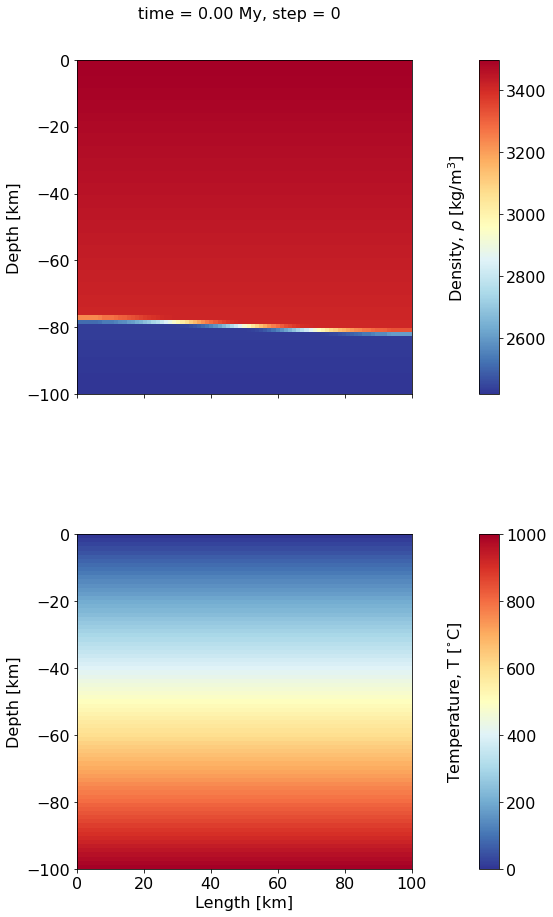

In [42]:
if (save_images) or (plot_first):
    aux = 0
    if ("temperature" or ("velocity_x" and "velocity_x")) in dataset.data_vars:
        aux += 1
        if "temperature" in dataset.data_vars:
            t_min = dataset.temperature.min() 
            t_max = dataset.temperature.max()
        if ("velocity_x" and "velocity_x") in dataset.data_vars:
            to_mm_yr = 365 * 24 * 60 * 60 * 1000.0
            desired_mm_per_year_value = 50.0
            v_key = desired_mm_per_year_value / to_mm_yr / v_max
            v_scale = 0.25 # If set to <n>, max velocity arrows will have the size of dataset.x.max()/<n>
    if "strain_rate" in dataset.data_vars:
        e_min, e_max = dataset.strain_rate.min(), dataset.strain_rate.max()
        aux += 1
    if "viscosity" in dataset.data_vars:
        eta_min, eta_max = float(dataset.attrs["viscosity_min"]), float(dataset.attrs["viscosity_max"])
        aux += 1
    if "surface" in dataset.data_vars:
        w_min, w_max = -10, 10 # dataset.surface.min()/1.0e3, dataset.surface.max()/1.0e3
        aux += 1
    if "density" in dataset.data_vars:
        aux += 1

    aux_size_x = np.round(float(abs(dataset.x[-1]/1.0e6)), 1)
    aux_size_z = np.round(float(abs(dataset.z[0]/1.0e6)), 1)
    
    aux_size_x = np.max([aux_size_x,2])
    aux_size_z = np.max([aux_size_z,2])
    
    # Create the colors to plot the density
    cr = 255.0
    color_air = (255.0 / cr, 255.0 / cr, 255.0 / cr)
    color_continental_crust = (228.0 / cr, 156.0 / cr, 124.0 / cr)
    color_continental_mantle = (240.0 / cr, 209.0 / cr, 188.0 / cr)
    color_oceanic_crust = (155.0 / cr, 194.0 / cr, 155.0 / cr)
    color_oceanic_mantle = (207.0 / cr, 226.0 / cr, 205.0 / cr)
    colors = [
        color_air,
        color_continental_crust, 
        color_continental_mantle, 
        color_oceanic_crust, 
        color_oceanic_mantle
    ]

    SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 16, 16, 16

    plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
    plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
    plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
    plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

    hspace = 0.2

    start = 0
    end = dataset.time.size - 1
    step = 1
    
    if (plot_first):
        start = 0
        end = 1
        step = 1

    # Corrects an unintended fontsize on the first run for the quiverkey
    quiverkey_font = FontProperties()
    quiverkey_font.set_size(MEDIUM_SIZE)

    for i in range(start, end, step):
        subplot_num = 0
        per = np.round(100*(i+1-start)/(end-start), 2)
        print(f'output {i}/{end-1}, {per:.2f}%', end='\r')

        data = dataset.isel(time=i)

        fig, axs = plt.subplots(aux, 1, figsize=(3*aux_size_x, aux*4*aux_size_z), sharex=True, facecolor="white")
        fig.subplots_adjust(hspace=hspace)

        if "surface" in dataset.data_vars:
            if (i == 0) or (start != 0): 
                data_0 = dataset.isel(time=0)
                h_air = np.round(np.mean(data_0.surface/1.0e3)) # Estimates air layer thickness based on the first step
            im = axs[subplot_num].hlines(0, data.surface.x[0]/1.0e3, data.surface.x[-1]/1.0e3, linestyle="solid", color="grey")
            im = axs[subplot_num].plot(data.surface.x/1.0e3, data.surface/1.0e3 - h_air)
            axs[subplot_num].set_ylim(-10, 10)
            axs[subplot_num].set_ylim(w_min, w_max)
            axs[subplot_num].set_ylabel("Elevation [km]")
            surface_subplot_num = subplot_num
            imshow_box = np.array(axs[subplot_num].get_position()) # Backup Bbox to be used if no other data_vars is in the xarray.Dataset
            subplot_num += 1

        if "viscosity" in dataset.data_vars:
            im = axs[subplot_num].imshow(data.viscosity.T[::-1], 
                                         extent=[data.x.min()/1.0e3, data.x.max()/1.0e3, data.z.min()/1.0e3, data.z.max()/1.0e3], 
                                         norm=LogNorm(vmin=eta_min, vmax=eta_max),
                                         cmap="viridis")
            cax = inset_axes(axs[subplot_num], 
                             width=colorbar_width, 
                             height="100%", 
                             loc='center left', 
                             bbox_to_anchor=(colorbar_text_pos_left, 0., 0.3, 1), 
                             bbox_transform=axs[subplot_num].transAxes, 
                             borderpad=0)
            axs[subplot_num].set_aspect("equal")
            axs[subplot_num].set_ylabel("Depth [km]")
            cbar = fig.colorbar(im, cax=cax)
            cbar.set_label(r'Viscosity, $\eta$ [Pa.s]', rotation=90, labelpad=colorbar_text_labelpad)
            imshow_box = np.array(axs[subplot_num].get_position())
            if (follow_particle):
                im = axs[subplot_num].plot(particle_x/1.0e3, particle_z/1.0e3, color="red")
                im = axs[subplot_num].scatter(particle_x[i]/1.0e3, particle_z[i]/1.0e3, color="blue", zorder=10)
            subplot_num += 1
            
        if "density" in dataset.data_vars:
            im = axs[subplot_num].imshow(data.density.T[::-1], 
                                         extent=[data.x.min()/1.0e3, data.x.max()/1.0e3, data.z.min()/1.0e3, data.z.max()/1.0e3], 
                                         cmap="RdYlBu_r")
            cax = inset_axes(axs[subplot_num], 
                             width=colorbar_width, 
                             height="100%", 
                             loc='center left', 
                             bbox_to_anchor=(colorbar_text_pos_left, 0., 0.3, 1), 
                             bbox_transform=axs[subplot_num].transAxes, 
                             borderpad=0)
            axs[subplot_num].set_aspect("equal")
            axs[subplot_num].set_ylabel("Depth [km]")
            cbar = fig.colorbar(im, cax=cax)
            cbar.set_label(r'Density, $\rho$ [kg/m$^3$]', rotation=90, labelpad=colorbar_text_labelpad)
            imshow_box = np.array(axs[subplot_num].get_position())
            subplot_num += 1

        if ("temperature" or ("velocity_x" and "velocity_x")) in dataset.data_vars:
            if "temperature" in dataset.data_vars:
                im = axs[subplot_num].imshow(data.temperature.T[::-1], 
                                             extent=[data.x.min()/1.0e3, data.x.max()/1.0e3, data.z.min()/1.0e3, data.z.max()/1.0e3], 
                                             vmin=t_min, vmax=t_max, 
                                             cmap="RdYlBu_r")
                cax = inset_axes(axs[subplot_num], 
                                 width=colorbar_width, 
                                 height="100%", 
                                 loc='center left', 
                                 bbox_to_anchor=(colorbar_text_pos_left, 0., 0.3, 1), 
                                 bbox_transform=axs[subplot_num].transAxes, 
                                 borderpad=0)
                cbar = fig.colorbar(im, cax=cax)
                cbar.set_label(r'Temperature, T [$^{\circ}$C]', rotation=90, labelpad=colorbar_text_labelpad)
            if ("velocity_x" and "velocity_x") in dataset.data_vars:
                num_vectors = 15
                vel_aux = data[dict(x=slice(None, None, num_vectors), z=slice(None, None, num_vectors))]
                v_label = '$\overrightarrow{v} =$' + f'{np.round(float(v_key*v_max*to_mm_yr))} [mm/yr]'
                im = axs[subplot_num].quiver(vel_aux.x/1.0e3, 
                                             vel_aux.z/1.0e3, 
                                             vel_aux.velocity_x.values.T, 
                                             vel_aux.velocity_z.values.T, 
                                             scale=v_scale)
                # arrow_size = 0.085 * dataset.x.max()/1.0e3
                # dd = 100
                # dx, dz = 1150 + arrow_size, 2 * dd
                # x0, z0 = dataset.x.max()/1.0e3 - dx - dd,  dataset.z.min()/1.0e3 + dd
                im = axs[subplot_num].quiverkey(im, 
                                                X=0.5,#(x0+arrow_size)/(dataset.x.max()/1.0e3),
                                                Y=-0.1,#1-(z0+dd)/(dataset.z.min()/1.0e3),
                                                U=v_key,
                                                label=v_label, 
                                                labelpos='E', 
                                                fontproperties=quiverkey_font) # fontproperties corrects an unintended behaviour where the incorrect fontsize was used during 1st run
                # im = axs[subplot_num].add_patch(FancyBboxPatch((x0, z0), dx, dz, boxstyle='round, rounding_size=25', facecolor = 'white'))
            # axs[subplot_num].set_aspect("equal")
            axs[subplot_num].set_aspect("equal")
            axs[subplot_num].set_ylabel("Depth [km]")
            imshow_box = np.array(axs[subplot_num].get_position())
            subplot_num += 1

        if "strain_rate" in dataset.data_vars:
            im = axs[subplot_num].imshow(data.strain_rate.T[::-1],  
                                         extent=[data.x.min()/1.0e3, data.x.max()/1.0e3, data.z.min()/1.0e3, data.z.max()/1.0e3], 
                                         norm=LogNorm(vmin=e_min, vmax=e_max), 
                                         alpha=1.0,
                                         zorder=100,
                                         cmap=plt.get_cmap("viridis"))
            cax = inset_axes(axs[subplot_num], 
                             width=colorbar_width, 
                             height="100%", 
                             loc='center left', 
                             bbox_to_anchor=(colorbar_text_pos_left, 0., 0.3, 1), 
                             bbox_transform=axs[subplot_num].transAxes, 
                             borderpad=0)
            axs[subplot_num].set_aspect("equal")
            axs[subplot_num].set_ylabel("Depth [km]")
            cbar = fig.colorbar(im, cax=cax)
            cbar.set_label(r'Strain rate, $\dot{\epsilon}$ [s$^{-1}$]', rotation=90, labelpad=colorbar_text_labelpad)
            imshow_box = np.array(axs[subplot_num].get_position())
            subplot_num += 1

        # Fix surface plot aspect ratio and position
        if "surface" in dataset.data_vars:
            axs[surface_subplot_num].set_aspect(dataset.surface.x.max()/1.0e3/120)
            plot_box = np.array(axs[surface_subplot_num].get_position())    
            new_plot_box = Bbox([[imshow_box[0, 0], plot_box[0, 1]], [imshow_box[1, 0], plot_box[1, 1]]])
            axs[surface_subplot_num].set_position(new_plot_box)   

        axs[subplot_num-1].set_xlabel("Length [km]")
        plt.suptitle("time = {:.2f} My, step = {}".format(np.round(data.time.item(), 2), data.step.item()), ha='center', y=0.9, x=0.5)
        fig.align_ylabels(axs[:])
        plt.savefig(f"{output_path}/{model_name}_output_{str(i).zfill(6)}.png", dpi=300)
        if (plot_first==False):
            plt.close('all')

## Make video with output images

In [ ]:
line = f"ffmpeg -r 7 -i {model_path}/_output/{model_name}_output_%06d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p {model_path}/_output/{model_name}.mp4"
print(line)
if (make_video):
    !rm {model_path}/_output/{model_name}.mp4
    !ffmpeg -r 7 -i {model_path}/_output/{model_name}_output_%06d.png -c:v libx264 -vf fps=25 -pix_fmt yuv420p {model_path}/_output/{model_name}.mp4

In [ ]:
line = 'ffmpeg -ss 0 -t 10 -i {model_path}/_output/{model_name}.mp4 -vf "fps=10,scale=1080:-1:flags=lanczos,split[s0][s1];[s0]palettegen[p];[s1][p]paletteuse" -loop 0 {model_path}/_output/{model_name}.gif'
print(line)
if (make_gif):
    !rm {model_path}/_output/{model_name}.gif
    !ffmpeg -ss 0 -t 10 -i {model_path}/_output/{model_name}.mp4 -vf "fps=100,scale=1080:-1:flags=lanczos,split[s0][s1];[s0]palettegen[p];[s1][p]paletteuse" -loop 0 {model_path}/_output/{model_name}.gif